In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

We define a function $ f(x) = 2 - x + ln(x) $, whose roots we ought to find. The approximate values of the roots can be infered from the graph below.

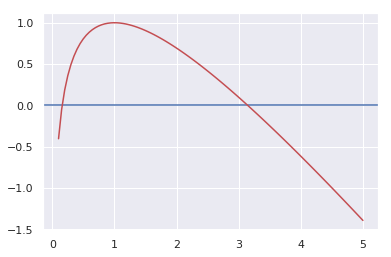

In [2]:
def f(x):
    return (2 - x + np.log(x))

def fprime(x):
    return 1/x - 1

x = np.linspace(0.1,5,100)
y = f(x)
plt.axhline()
plt.plot(x,y,color='r')

The following function is drawn on the idea of fixed point methods:

If we want a solution to an equation of the form $ g(x) = x $, that is, if we want to find a fixed point of $ g $, we may lay down the following iterative method:

$$ g(x_{n-1}) = x_n $$

The hope is that it converges, $ \lim_{x \to \infty} x_n = x $. If it does, then the limit is necessarily a fixed point, as long as g is continuous, because

$$ x = \lim_{x \to \infty} x_n = \lim_{x \to \infty} f(x_{n-1}) = f( \lim_{x \to \infty} x_{n-1}) = f(x) $$

So, convergence of fixed point methods is a powerfull idea: if there are theoretical guaranties for convergence, these are theoretical guaranties for convergence to a fixed point.

When trying to solve an equation of the form $ f(x) = 0 $, it is then useful to recast it into a fixed point format. Below, we try the following:

$$ g(x) = f(x) + x $$

so that $ g(x) = x \iff f(x) = 0 $.

In [3]:
def find_root(f, n_iter=50, x_init=1):
    x = x_init
    for _ in range(n_iter):
        x = f(x) + x
        if np.abs(f(x)) < 1e-8:
            break
    return x

In [4]:
find_root(f)

3.146193215112132

It finds the rightmost root, even though we started closest to the left one. Let's try starting from the left:

In [5]:
#Logaritmo de negativo

find_root(f, x_init=0.1)

/home/db/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


nan

The nan comes from the fact that x becomes negative through the iterative process (as the error message indicates). This means our scheme does not even necessarily walk in the right direction. How could we know which is the right direction, left or right? Looking only to the value of the function at the current point is certainly not enough. To gain more information, therefore, we should at least look at the first derivative.

But, first, let's try another iterative scheme. We make it trying to "solve" 2 - x + ln(x) = 0 for the x inside of the logarithm: that is, we write: $ x = exp(x-2) $, and make

$ x_n = exp(x_{n-1} - 2) $.

This corresponds to a fixed point method with $ g(x) = exp(ln(x) - f(x)) $. Of course it does not make so much sense for a general f. But it will work in practice:

In [6]:
def find_root(f, n_iter=50, x_init=1):
    x = x_init
    x_seq = []
    f_seq = []
    for _ in range(n_iter):
        x = np.exp(np.log(x) - f(x))
        x_seq.append(x)
        f_seq.append(f(x))
        if np.abs(f(x)) < 1e-8:
            break
    return x, x_seq, f_seq

In [7]:
x, x_seq, f_seq = find_root(f)

It won't work for $ f(x) = x^2 - 2 $:

In [8]:
def f_(x):
    return x**2 - 2

x, _, _ = find_root(f_, n_iter=100)
x

0.20413259596905037

Above, we returned the sequence of values of x and f through the iterations. With this, we might plot the value of $ |x_n-x| / |x_{n-1} - x| $. We see it has a reasonable upper bound, which we call $ M $. Then:

$$ |x_n-x| \leq M |x_{n-1} - x| $$

That is, the method converges linearly.

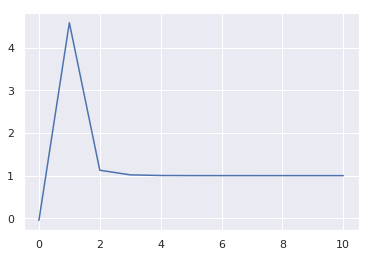

In [9]:
plt.plot(np.array(x_seq[1:]-x)/np.array(x_seq[:-1]-x))

But it does not reasonably follow a quadratic convergence:

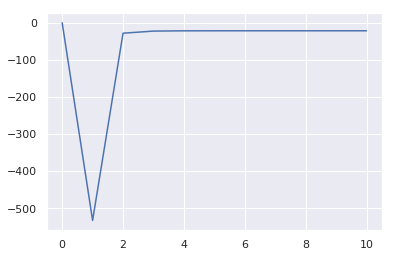

In [10]:
plt.plot(np.array(x_seq[1:]-x)/np.array(x_seq[:-1]-x)**2)

We have given reason enough to develop a better fixed point method. As we argued, we might use the first derivative in order to indicate us the direction of change. It could, at the same time, indicate us the amount of change, because, if the function is well approximated by the first terms of a Taylor expansion, then

$$ f(x+\delta x) \sim f(x) + f'(x) \delta x $$

So, if we want $ f(x+\delta x) \sim 0 $, we might try:

$$ \delta x \sim \frac{-f(x)}{f'(x)} $$

This leads us to the iterative scheme:

$$ x_n = x_{n-1} - \frac{f(x_{n-1})}{f'(x_{n-1})} $$

Theory gives some guaranties to this method, for well behaved functions $ f $ and for good starting points. If, aditionally, $ f'(x) = 0 $ at the solution x, then the method will converge quadratically.

In [11]:
def newton_method(f, fprime, n_iter=50, x_init=1):
    x = x_init
    x_seq = []
    f_seq = []
    for _ in range(n_iter):
        x = x - f(x)/fprime(x)
        x_seq.append(x)
        f_seq.append(f(x))
        if np.abs(f(x)) < 1e-8:
            break
    return x, x_seq, f_seq

In [12]:
x, x_seq, f_seq = newton_method(f, fprime, x_init=0.1)
x

0.15859433954808164

The convergence is now quadratic:

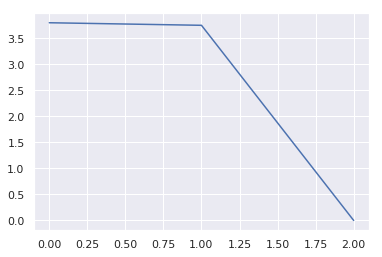

In [13]:
plt.plot(np.abs(np.array(x_seq[1:]-x))/np.abs(np.array(x_seq[:-1]-x)**2))

Instead of providing the explicit form of the derivative f, we might use numerical differentiation. One option is to use pytorch's autodiferentiation functionalities:

In [14]:
import torch
from torch.autograd import Variable

#Redefine f using pytorch's computations:
def f(x):
    return 2 - x + torch.log(x)

def newton_method(f, n_iter=50, x_init=1.0):
    x = Variable(torch.tensor(x_init), requires_grad=True)
    x.cuda()
    for _ in range(n_iter):
        x = x.clone().detach().requires_grad_(True)
        y = f(x)
        #We "backward propagate" the gradient of y, that is just f(x),
        # and collect it back at x, using x.grad. This gives us the
        # derivative of f at x, which we can use to define the
        # iteration.
        y.backward()
        x = x - y/x.grad
        if torch.abs(y) < 1e-8:
            break
    return x

And we have again the correct answer:

In [16]:
newton_method(f, x_init=0.1)

tensor(0.1586, grad_fn=<SubBackward0>)